### Thesaurus

Synonym, antonym dictionary.

..or define word by using hypernym, hyponym.

ex) WordNet

It has disadvantages..

* meaning of word changes as time goes by.

* using human resources.

* hard to recognize subtle meaning. 

## Statistics based method

#### Corpus

large text dataset; It contains human's natural language knowledge.

In [7]:
# Preprocessing

text = "You say goodbye and I say hello."

text = text.lower()
text = text.replace('.', ' .')
words = text.split(' ')

print(words)

##########################

# dictionary
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:

        new_id = len(word_to_id) # index

        word_to_id[word] = new_id
        id_to_word[new_id] = word

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [8]:
import numpy as np

corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)

print(corpus)

[0 1 2 3 4 1 5 6]


In [9]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}

    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

### Distributional representation

Vector that precisely represents meaning of word.

#### Distributional hypothesis

<center>*"Meaning of word is represented by nearby words."*</center>

<center>"Context" makes meaning of word!</center>

#### Context

Context : certain word's nearby words in sentence.

Window size: size of context.

ex) you say <u>goodbye</u> and i say hello.

you, say, and, i -> window size = 2


#### <u> Count words that appear near a certain word </u> : Statistical based method!

In [10]:
import sys
import numpy as np

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


If window size = 1, 

word 'you's context table be like..

|..|you|say|goodbye|and|i|hello|.|
|--|---|---|-------|---|-|-----|-|
|you|0|1|0|0|0|0|0|


Result; this table is <u>co-occurrence matrix</u>

|..|you|say|goodbye|and|i|hello|.|
|--|---|---|-------|---|-|-----|-|
|you|0|1|0|0|0|0|0|
|say|1|0|1|0|1|1|0|
|goodbye|0|1|0|1|0|0|0|
|and|0|0|1|0|1|0|0|
|i|0|1|0|1|0|0|0|
|hello|0|1|0|0|0|0|1|
|.|0|0|0|0|0|1|0|

In [11]:
C = np.array([
    [0,1,0,0,0,0,0],
    [1,0,1,0,1,1,0],
    [0,1,0,1,0,0,0],
    [0,0,1,0,1,0,0],
    [0,1,0,1,0,0,0],
    [0,1,0,0,0,0,1],
    [0,0,0,0,0,1,0],
], dtype = np.int32)

print(C[word_to_id['goodbye']])

[0 1 0 1 0 0 0]


In [12]:
def create_co_matrix(corpus, vocab_size, window_size = 1):

    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype = np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):

            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

        
    return co_matrix

### Similarity between words

#### cosine similarity

In [13]:
def cos_similarity(x, y):

    eps = 1e-8

    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)

    return np.dot(nx, ny)

In [ ]:
# similarity between 'i' and 'you'
text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]

print(cos_similarity(c0, c1))

0.7071067758832467


In [15]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top = 5):

    # 1. query check
    if query not in word_to_id:
        print("error!")
        return
    
    print('\n[query] ' + query)

    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 2. cos similarity
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        # [1, 0, 2, 0, 1, 2, ...], [1, 2, 0, 2, 1, 2, ...]
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 3. descending order
    count = 0
    for i in (-1 * similarity).argsort(): # i is descending order 'index'.
        if id_to_word[i] == query: continue # me
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top: return 

most_similar('you', word_to_id, id_to_word, C, top = 5)


[query] you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


### How to improve this statistical method?

problem) 'High frequency word' -> <u>'the'</u>

#### PMI: Pointwise Mutual Information

$$PMI(x, y) = \log_2 \frac{P(x, y)}{P(x)P(y)} = \log_2 \frac{C(x, y)*N}{C(x)C(y)}$$

N = number of words

C(x) = number of certain word x

#### PPMI: Positive PMI

$$PPMI(x, y) = max(0, PMI(x,y))$$

because of log_2(0) problem.

In [ ]:
def ppmi(C, verbose = False, eps = 1e-8):

    M = np.zeros_like(C, dtype = np.float32)
    N = np.sum(C) # all sum
    S = np.sum(C, axis = 0) # column sum
    total = C.shape[0] * C.shape[1]

    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)

            # be aware of difference between C, S.
            # in this case, C[i, j] ~> i, j should be located nearby(context size).

            M[i, j] = max(0, pmi) # ppmi

            if verbose:
                cnt += 1
                if cnt % (total // 100) == 0:
                    print('%1.f%% completed' % (100 * cnt / total))

    return M

W = ppmi(C)
print(W)

[[0.        1.8073549 0.        0.        0.        0.        0.       ]
 [1.8073549 0.        0.8073549 0.        0.8073549 0.8073549 0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.        1.8073549 0.        1.8073549 0.        0.       ]
 [0.        0.8073549 0.        1.8073549 0.        0.        0.       ]
 [0.        0.8073549 0.        0.        0.        0.        2.807355 ]
 [0.        0.        0.        0.        0.        2.807355  0.       ]]


#### But we still have problem) "Curse of dimensionality"

### solution) Dimensionality reduction: SVD!

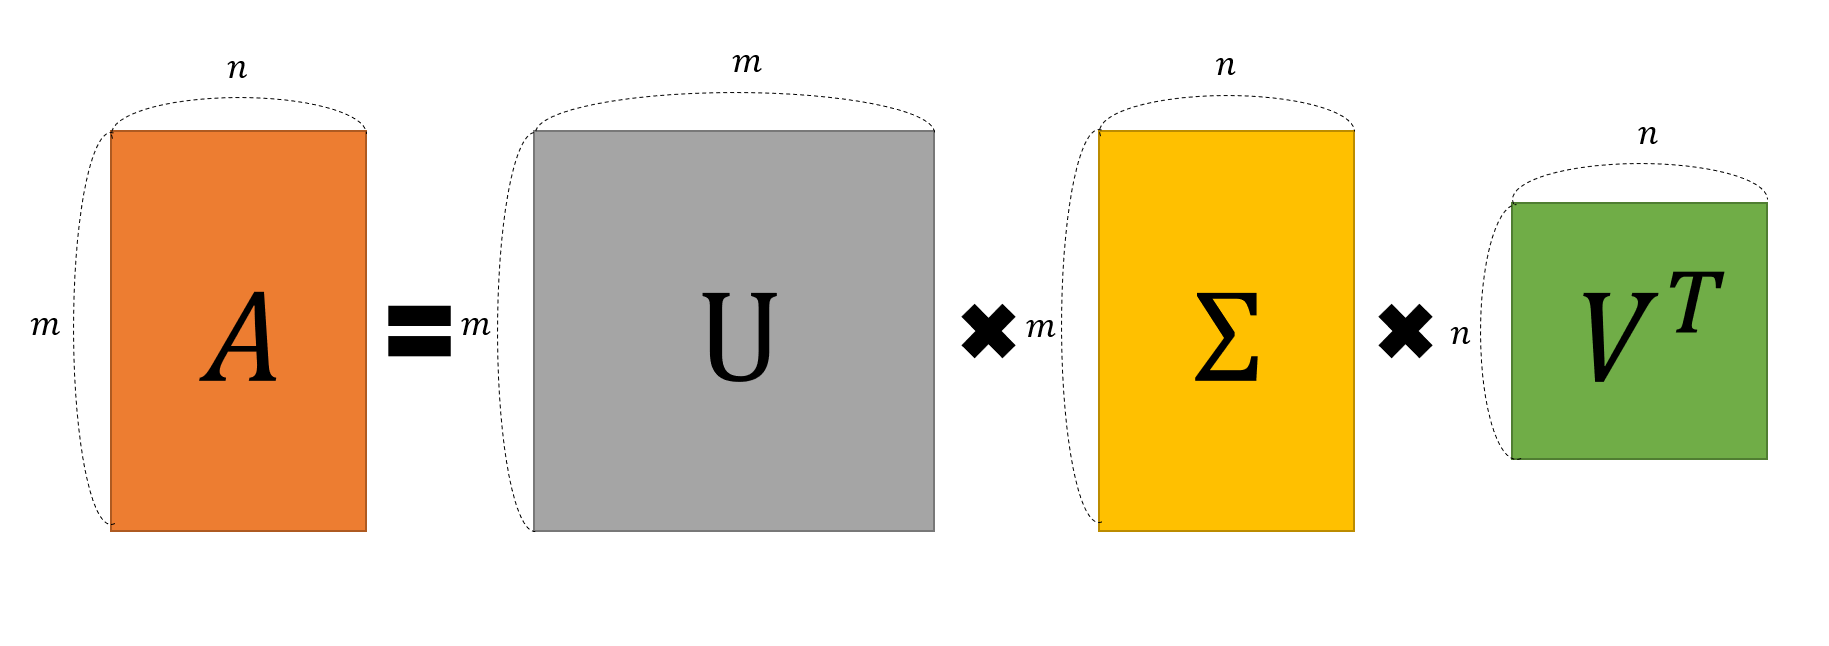

U, V are orthogonal matrix.

in $\Sigma$, vectors are ordered by descending order of 'singular value'

singular value means, 'importance of certain axis'!

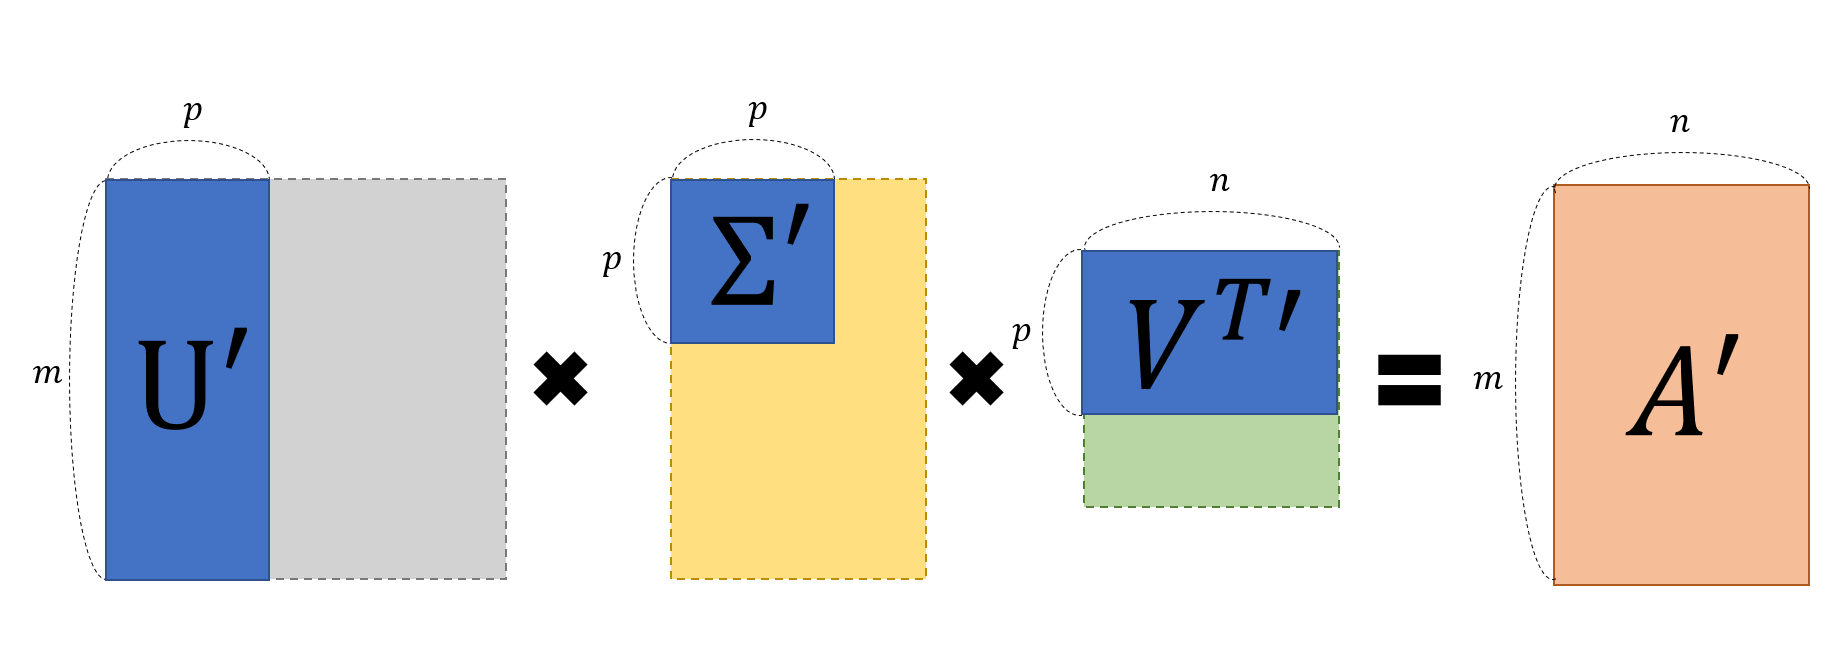

focus on U, we can find that word vector's dimensionality reduced.

In [ ]:
from sklearn.utils.extmath import randomized_svd

# original method. O(n^3)
U, S, V = np.linalg.svd(W)

# n_components: number of main upper components.
# n_iter: precision goes up, but longer time.
U, S, V = randomized_svd(W, n_components = 5, n_iter=5, random_state=None)

print(C[0]) # co-occurence matrix
print([W[0]]) # ppmi
print(U[0]) # SVD

print(U[0, :2]) # SVD ~ dimensionality reduction

[0 1 0 0 0 0 0]
[array([0.       , 1.8073549, 0.       , 0.       , 0.       , 0.       ,
       0.       ], dtype=float32)]
[ 3.4094909e-01  2.9057264e-07 -3.4839511e-03 -1.2046573e-01
 -2.1911985e-01]
[3.4094909e-01 2.9057264e-07]


: 

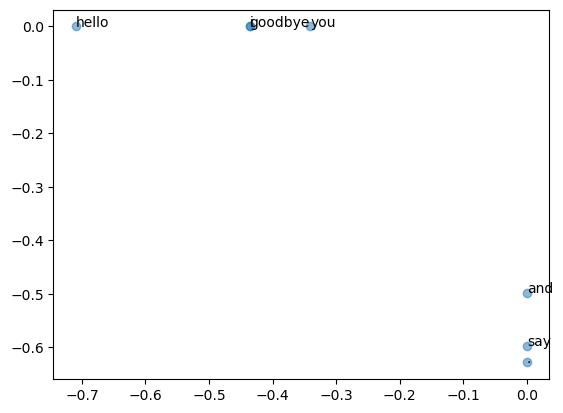

In [24]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha = 0.5)
plt.show()

### PTB: Penn Treebank

big corpus!